# Weighted Belief Propagation Decoding

This notebooks implements the *Weighted Belief Propagation* (BP) algorithm as proposed by Nachmani *et al.* in [1].
The main idea is to leverage BP decoding by additional trainable weights that scale each outgoing variable node (VN) and check node (CN) message. These weights provide additional degrees of freedom and can be trained by stochastic gradient descent (SGD) to improve the BP performance for the given code. If all weights are initialized with *1*, the algorithm equals the *classical* BP algorithm and, thus, the concept can be seen as a generalized BP decoder.

Our main focus is to show how Sionna can lower the barrier-to-entry for state-of-the-art research.
For this, you will investigate:

* How to implement the multi-loss BP decoding with Sionna
* How a single scaling factor can lead to similar results
* What happens for training of the 5G LDPC code

The setup includes the following components:

- LDPC BP Decoder
- Gaussian LLR source

Please note that we implement a simplified version of the original algorithm consisting of two major simplifications:

1. ) Only outgoing variable node (VN) messages are weighted. This is possible as the VN operation is linear and it would only increase the memory complexity without increasing the *expressive* power of the neural network.

2. ) We use the same shared weights for all iterations. This can potentially influence the final performance, however, simplifies the implementation and allows to run the decoder with different number of iterations.


**Note**: If you are not familiar with all-zero codeword-based simulations please have a look into the [Bit-Interleaved Coded Modulation](https://nvlabs.github.io/sionna/examples/Bit_Interleaved_Coded_Modulation.html) example notebook first.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Weighted BP for BCH Codes](#Weighted-BP-for-BCH-Codes)
    * [Weights *before* Training and Simulation of BER](#Weights-before-Training-and-Simulation-of-BER)
    * [Training](#Training)
    * [Results](#Results)
* [Further Experiments](#Further-Experiments)
    * [Damped BP](#Damped-BP)
    * [Learning the 5G LDPC Code](#Learning-the-5G-LDPC-Code)
* [References](#References)

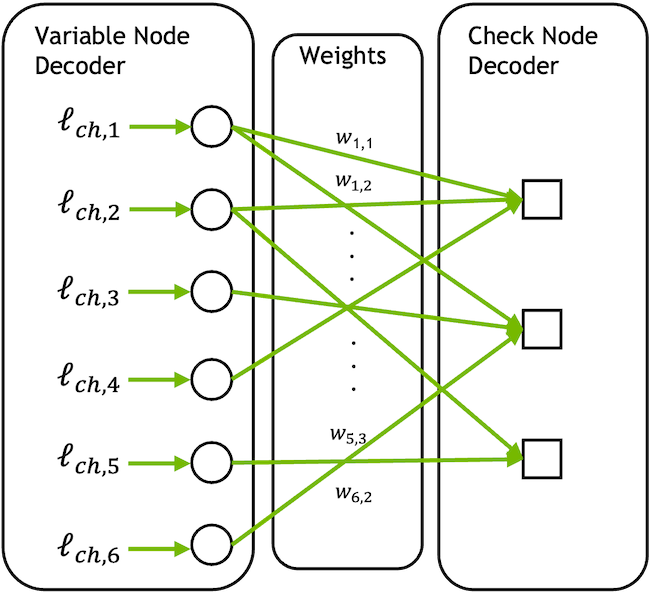

## GPU Configuration and Imports

In [58]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Import required Sionna components
from sionna.fec.ldpc import LDPCBPDecoder, LDPC5GEncoder, LDPC5GDecoder
from sionna.utils.metrics import BitwiseMutualInformation
from sionna.fec.utils import GaussianPriorSource, load_parity_check_examples
from sionna.utils import ebnodb2no, hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER

from tensorflow.keras.losses import BinaryCrossentropy

In [59]:
import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Weighted BP for BCH Codes

First, we define the trainable model consisting of:

- LDPC BP decoder
- Gaussian LLR source

The idea of the multi-loss function in [1] is to average the loss overall iterations, i.e., not just the final estimate is evaluated. This requires to call the BP decoder *iteration-wise* by setting `num_iter=1` and `stateful=True` such that the decoder will perform a single iteration and returns its current estimate while also providing the internal messages for the next iteration.

A few comments:

- We assume the transmission of the all-zero codeword. This allows to train and analyze the decoder without the need of an encoder. Remark: The final decoder can be used for arbitrary codewords.
- We directly generate the channel LLRs with `GaussianPriorSource`. The equivalent LLR distribution could be achieved by transmitting the all-zero codeword over an AWGN channel with BPSK modulation.
- For the proposed *multi-loss* [1] (i.e., the loss is averaged over all iterations), we need to access the decoders intermediate output after each iteration. This is done by calling the decoding function multiple times while setting `stateful` to True, i.e., the decoder continuous the decoding process at the last message state.

In [4]:
class WeightedBP(tf.keras.Model):
    """System model for BER simulations of weighted BP decoding.
    
    This model uses `GaussianPriorSource` to mimic the LLRs after demapping of 
    QPSK symbols transmitted over an AWGN channel.
    
    Parameters
    ----------
        pcm: ndarray
            The parity-check matrix of the code under investigation.
        
        num_iter: int 
            Number of BP decoding iterations.       
        
            
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat, loss):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.           
            
        loss: tf.float32
            Binary cross-entropy loss between `u` and `u_hat`.
    """
    def __init__(self, pcm, num_iter=5):
        super().__init__()

        # init components    
        self.decoder = LDPCBPDecoder(pcm,
                                     num_iter=1, # iterations are done via outer loop (to access intermediate results for multi-loss)
                                     stateful=True, # decoder stores internal messages after call
                                     hard_out=False, # we need to access soft-information
                                     cn_type="boxplus",
                                     trainable=True) # the decoder must be trainable, otherwise no weights are generated

        # used to generate llrs during training (see example notebook on all-zero codeword trick)
        self.llr_source = GaussianPriorSource()
        self._num_iter = num_iter

        self._bce = BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):     
        noise_var = ebnodb2no(ebno_db,
                              num_bits_per_symbol=2, # QPSK
                              coderate=coderate)        
        
        # all-zero CW to calculate loss / BER
        c = tf.zeros([batch_size, n]) 

        # Gaussian LLR source
        llr = self.llr_source([[batch_size, n], noise_var])

        # --- implement multi-loss as proposed by Nachmani et al. [1]---
        loss = 0 
        msg_vn = None # internal state of decoder
        for i in range(self._num_iter):
            c_hat, msg_vn = self.decoder((llr, msg_vn)) # perform one decoding iteration; decoder returns soft-values
            loss += self._bce(c, c_hat)  # add loss after each iteration
        
        loss /= self._num_iter # scale loss by number of iterations        

        return c, c_hat, loss

Load a parity-check matrix used for the experiment. We use the same BCH(63,45) code as in [1].
The code can be replaced by any parity-check matrix of your choice. 

In [5]:
pcm_id = 1 # (63,45) BCH code parity check matrix
pcm, k , n, coderate = load_parity_check_examples(pcm_id=pcm_id, verbose=True)

num_iter = 10 # set number of decoding iterations

# and initialize the model
model = WeightedBP(pcm=pcm, num_iter=num_iter)


n: 63, k: 45, coderate: 0.714


**Note**: weighted BP tends to work better for small number of iterations.
The effective gains (compared to the baseline with same number of iterations)
vanish with more iterations.

### Weights *before* Training and Simulation of BER

Let us plot the weights after initialization of the decoder to verify that everything is properly initialized.
This is equivalent the *classical* BP decoder.

Total number of weights:  432


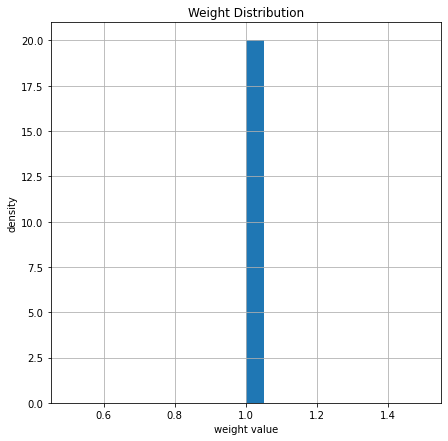

In [6]:
# count number of weights/edges
print("Total number of weights: ", np.size(model.decoder.get_weights()))

# and show the weight distribution
model.decoder.show_weights()

We first simulate (and store) the BER performance *before* training.
For this, we use the `PlotBER` class, which provides a convenient way to store the results for later comparison.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 8.8968e-02 | 9.7000e-01 |        5605 |       63000 |          970 |        1000 |         0.5 |reached target bit errors
      1.5 | 7.6238e-02 | 9.1600e-01 |        4803 |       63000 |          916 |        1000 |         0.3 |reached target bit errors
      2.0 | 6.1381e-02 | 8.2200e-01 |        3867 |       63000 |          822 |        1000 |         0.3 |reached target bit errors
      2.5 | 4.4190e-02 | 6.4700e-01 |        2784 |       63000 |          647 |        1000 |         0.3 |reached target bit errors
      3.0 | 3.1159e-02 | 4.8050e-01 |        3926 |      126000 |          961 |        2000 |         0.6 |reached target bit errors
      3.5 | 2.1778e-02 | 3.5700e-01 |        2744 |      126000 |          

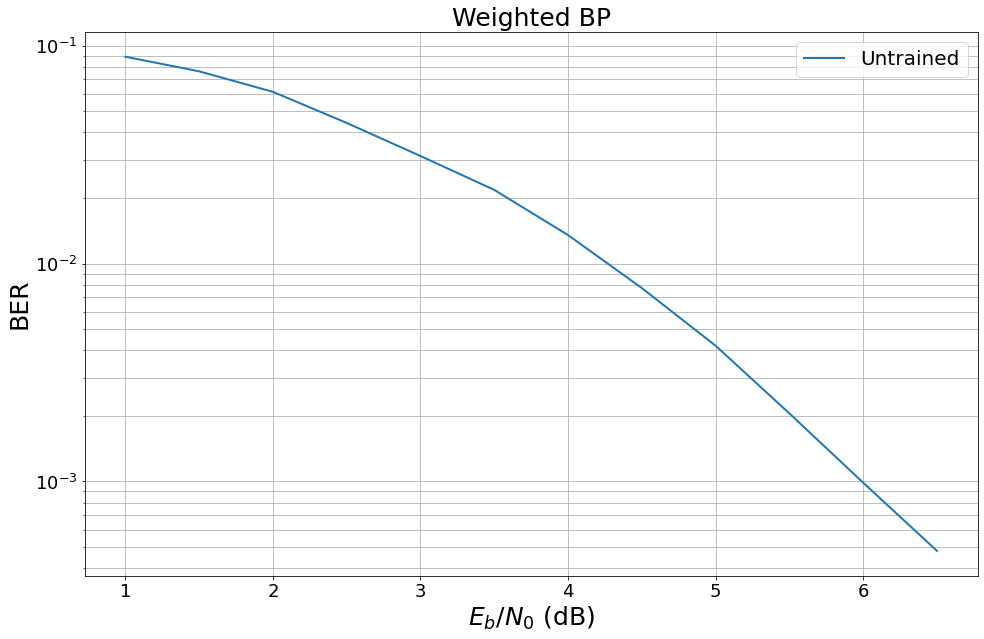

In [7]:
# SNR to simulate the results
ebno_dbs = np.array(np.arange(1, 7, 0.5))
mc_iters = 100 # number of Monte Carlo iterations

# we generate a new PlotBER() object to simulate, store and plot the BER results
ber_plot = PlotBER("Weighted BP")

# simulate and plot the BER curve of the untrained decoder
ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=1000,
                  num_target_bit_errors=2000, # stop sim after 2000 bit errors
                  legend="Untrained",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False);

### Training
We now train the model for a fixed number of SGD training iterations.

**Note**: this is a very basic implementation of the training loop.
You can also try more sophisticated training loops with early stopping, different hyper-parameters or optimizers etc. 

In [8]:
# training parameters
batch_size = 1000
train_iter = 200
ebno_db = 4.0
clip_value_grad = 10 # gradient clipping for stable training convergence

# bmi is used as metric to evaluate the intermediate results
bmi = BitwiseMutualInformation()

# try also different optimizers or different hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) 

for it in range(0, train_iter):
    with tf.GradientTape() as tape:
        b, llr, loss = model(batch_size, ebno_db)     

    grads = tape.gradient(loss, model.trainable_variables)
    grads = tf.clip_by_value(grads, -clip_value_grad, clip_value_grad, name=None)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # calculate and print intermediate metrics
    # only for information
    # this has no impact on the training
    if it%10==0: # evaluate every 10 iterations
        # calculate ber from received LLRs
        b_hat = hard_decisions(llr) # hard decided LLRs first
        ber = compute_ber(b, b_hat) 
        # and print results
        mi = bmi(b, llr).numpy() # calculate bit-wise mutual information
        l = loss.numpy() # copy loss to numpy for printing
        print(f"Current loss: {l:3f} ber: {ber:.4f} bmi: {mi:.3f}".format())
        bmi.reset_states() # reset the BMI metric

Current loss: 0.067097 ber: 0.0136 bmi: 0.911
Current loss: 0.046659 ber: 0.0111 bmi: 0.934
Current loss: 0.050064 ber: 0.0122 bmi: 0.901
Current loss: 0.049733 ber: 0.0109 bmi: 0.923
Current loss: 0.046720 ber: 0.0113 bmi: 0.936
Current loss: 0.042915 ber: 0.0130 bmi: 0.933
Current loss: 0.042055 ber: 0.0121 bmi: 0.940
Current loss: 0.053349 ber: 0.0132 bmi: 0.918
Current loss: 0.043389 ber: 0.0122 bmi: 0.935
Current loss: 0.041267 ber: 0.0128 bmi: 0.952
Current loss: 0.048322 ber: 0.0132 bmi: 0.933
Current loss: 0.049425 ber: 0.0129 bmi: 0.926
Current loss: 0.041751 ber: 0.0125 bmi: 0.952
Current loss: 0.041771 ber: 0.0119 bmi: 0.947
Current loss: 0.041278 ber: 0.0118 bmi: 0.949
Current loss: 0.040635 ber: 0.0127 bmi: 0.952
Current loss: 0.046098 ber: 0.0135 bmi: 0.940
Current loss: 0.041952 ber: 0.0134 bmi: 0.950
Current loss: 0.034445 ber: 0.0106 bmi: 0.958
Current loss: 0.037615 ber: 0.0114 bmi: 0.950


### Results

After training, the weights of the decoder have changed.
In average, the weights are smaller after training.

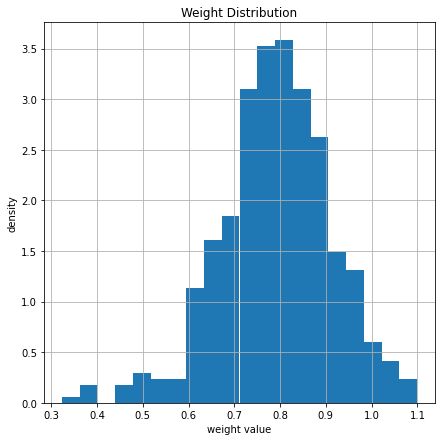

In [9]:
model.decoder.show_weights() # show weights AFTER training

And let us compare the new BER performance.
For this, we can simply call the ber_plot.simulate() function again as it internally stores all previous results (if `add_results` is True).

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 9.0952e-02 | 9.9800e-01 |        5730 |       63000 |          998 |        1000 |         0.3 |reached target bit errors
      1.5 | 7.8079e-02 | 9.7900e-01 |        4919 |       63000 |          979 |        1000 |         0.3 |reached target bit errors
      2.0 | 6.3794e-02 | 9.2700e-01 |        4019 |       63000 |          927 |        1000 |         0.3 |reached target bit errors
      2.5 | 4.9254e-02 | 8.1800e-01 |        3103 |       63000 |          818 |        1000 |         0.3 |reached target bit errors
      3.0 | 3.6048e-02 | 6.5000e-01 |        2271 |       63000 |          650 |        1000 |         0.3 |reached target bit errors
      3.5 | 2.3429e-02 | 4.3600e-01 |        2952 |      126000 |          

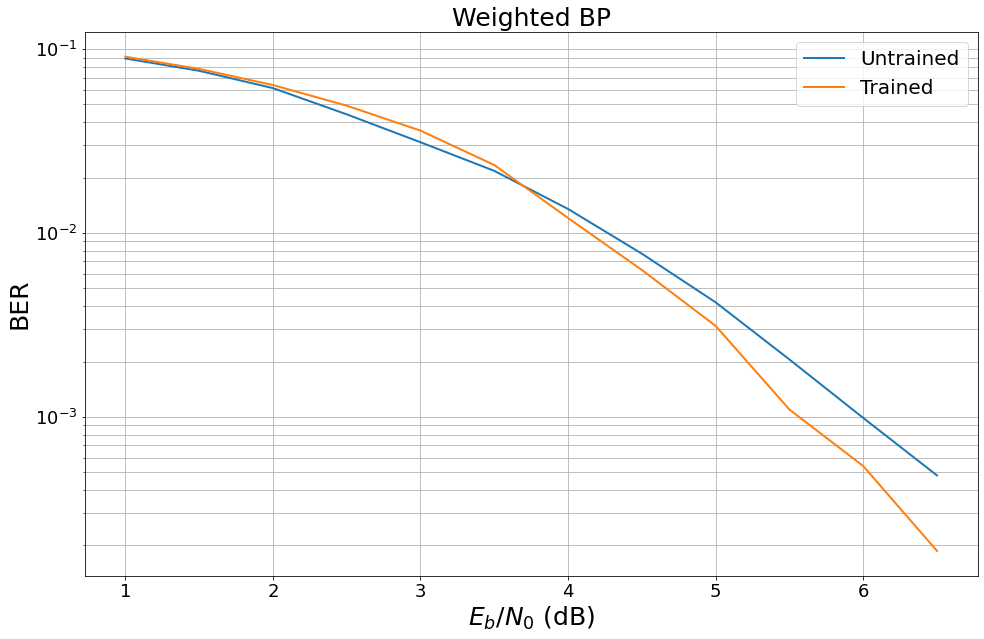

In [10]:
ebno_dbs = np.array(np.arange(1, 7, 0.5))
batch_size = 10000
mc_ites = 100

ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=1000,
                  num_target_bit_errors=2000, # stop sim after 2000 bit errors
                  legend="Trained",
                  max_mc_iter=mc_iters,
                  soft_estimates=True);

## Further Experiments

You will now see that the memory footprint can be drastically reduced by using the same weight for all messages.
In the second part we will apply the concept to the 5G LDPC codes.

### Damped BP 

It is well-known that scaling of LLRs / messages can help to improve the performance of BP decoding in some scenarios [3,4].
In particular, this works well for very short codes such as the code we are currently analyzing.

We now follow the basic idea of [2] and scale all weights with the same scalar.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 8.9905e-02 | 9.9200e-01 |        5664 |       63000 |          992 |        1000 |         0.3 |reached target bit errors
      1.5 | 7.5556e-02 | 9.7300e-01 |        4760 |       63000 |          973 |        1000 |         0.3 |reached target bit errors
      2.0 | 6.5492e-02 | 9.2700e-01 |        4126 |       63000 |          927 |        1000 |         0.3 |reached target bit errors
      2.5 | 4.9730e-02 | 7.9700e-01 |        3133 |       63000 |          797 |        1000 |         0.3 |reached target bit errors
      3.0 | 3.5460e-02 | 6.0500e-01 |        2234 |       63000 |          605 |        1000 |         0.3 |reached target bit errors
      3.5 | 2.2230e-02 | 4.0600e-01 |        2801 |      126000 |          

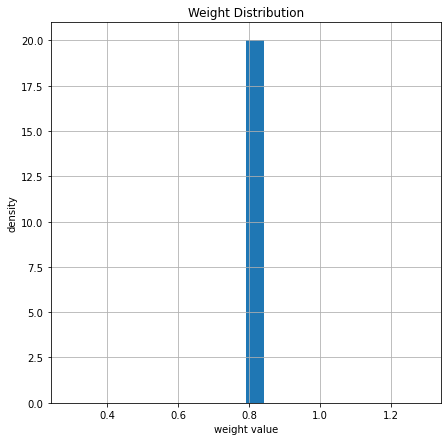

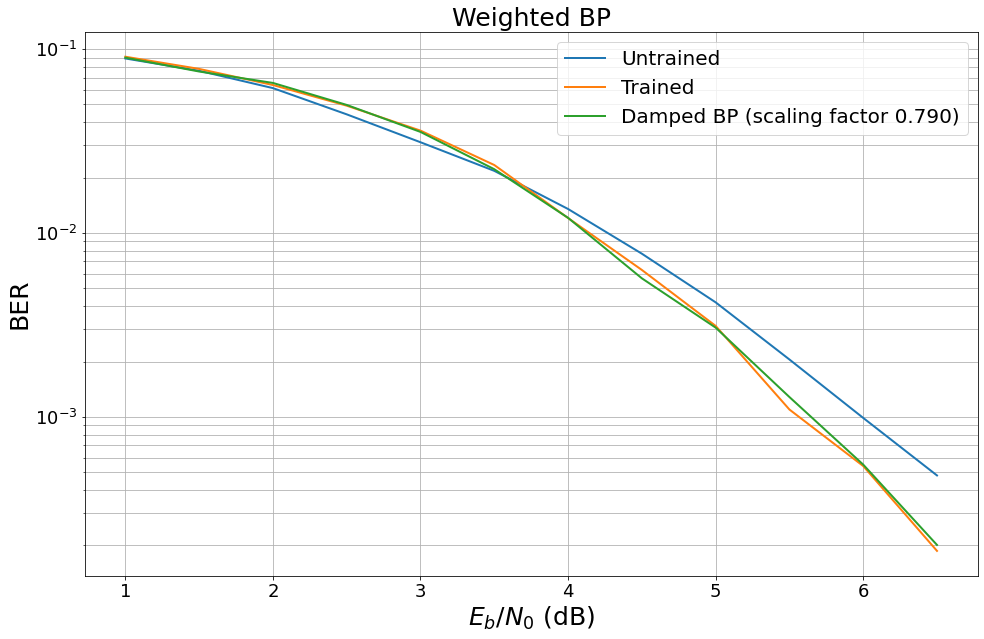

In [11]:
# get weights of trained model
weights_bp = model.decoder.get_weights()

# calc mean value of weights
damping_factor = tf.reduce_mean(weights_bp)

# set all weights to the SAME constant scaling
weights_damped = tf.ones_like(weights_bp) * damping_factor

# and apply the new weights
model.decoder.set_weights(weights_damped)

# let us have look at the new weights again
model.decoder.show_weights()

# and simulate the BER again
leg_str = f"Damped BP (scaling factor {damping_factor.numpy():.3f})"
ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=1000,
                  num_target_bit_errors=2000, # stop sim after 2000 bit errors
                  legend=leg_str,
                  max_mc_iter=mc_iters,
                  soft_estimates=True);

When looking at the results, we observe almost the same performance although we only scale by a single scalar.
This implies that the number of weights of our model is by far too large and the memory footprint could be reduced significantly.
However, isn't it fascinating to see that this simple concept of weighted BP leads to the same results as the concept of *damped BP*?

**Note**: for more iterations it could be beneficial to implement an individual damping per iteration.

### Learning the 5G LDPC Code

In this Section, you will experience what happens if we apply the same concept to the 5G LDPC code (including rate matching).

For this, we need to define a new model.

In [12]:
class WeightedBP5G(tf.keras.Model):
    """System model for BER simulations of weighted BP decoding for 5G LDPC codes.
    
    This model uses `GaussianPriorSource` to mimic the LLRs after demapping of 
    QPSK symbols transmitted over an AWGN channel.
    
    Parameters
    ----------
        k: int
            Number of information bits per codeword.
        
        n: int 
            Codeword length.
        
        num_iter: int
            Number of BP decoding iterations.
            
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat, loss):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.           
            
        loss: tf.float32
            Binary cross-entropy loss between `u` and `u_hat`.
    """
    def __init__(self, k, n, num_iter=20):
        super().__init__()

        # we need to initialize an encoder for the 5G parameters
        self.encoder = LDPC5GEncoder(k, n)
        self.decoder = LDPC5GDecoder(self.encoder,
                                     num_iter=1, # iterations are done via outer loop (to access intermediate results for multi-loss)
                                     stateful=True,
                                     hard_out=False,
                                     cn_type="boxplus",
                                     trainable=True)

        self.llr_source = GaussianPriorSource()
        self._num_iter = num_iter
        self._coderate = k/n

        self._bce = BinaryCrossentropy(from_logits=True)
    def call(self, batch_size, ebno_db):     
        
        noise_var = ebnodb2no(ebno_db,
                              num_bits_per_symbol=2, # QPSK
                              coderate=self._coderate)        
        
        # BPSK modulated all-zero CW
        c = tf.zeros([batch_size, k]) # decoder only returns info bits 

        # use fake llrs from GA
        # works as BP is symmetric
        llr = self.llr_source([[batch_size, n], noise_var])

        # --- implement multi-loss is proposed by Nachmani et al. ---
        loss = 0 
        msg_vn = None
        for i in range(self._num_iter):
            c_hat, msg_vn = self.decoder((llr, msg_vn)) # perform one decoding iteration; decoder returns soft-values
            loss += self._bce(c, c_hat)  # add loss after each iteration
        
        return c, c_hat, loss

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6527e-01 | 1.0000e+00 |       66108 |      400000 |         1000 |        1000 |         1.0 |reached target bit errors
     0.25 | 1.4461e-01 | 1.0000e+00 |       57842 |      400000 |         1000 |        1000 |         0.9 |reached target bit errors
      0.5 | 1.2148e-01 | 9.9900e-01 |       48591 |      400000 |          999 |        1000 |         1.0 |reached target bit errors
     0.75 | 9.4380e-02 | 9.8300e-01 |       37752 |      400000 |          983 |        1000 |         0.9 |reached target bit errors
      1.0 | 6.7870e-02 | 9.4500e-01 |       27148 |      400000 |          945 |        1000 |         1.0 |reached target bit errors
     1.25 | 4.0090e-02 | 7.9100e-01 |       16036 |      400000 |          

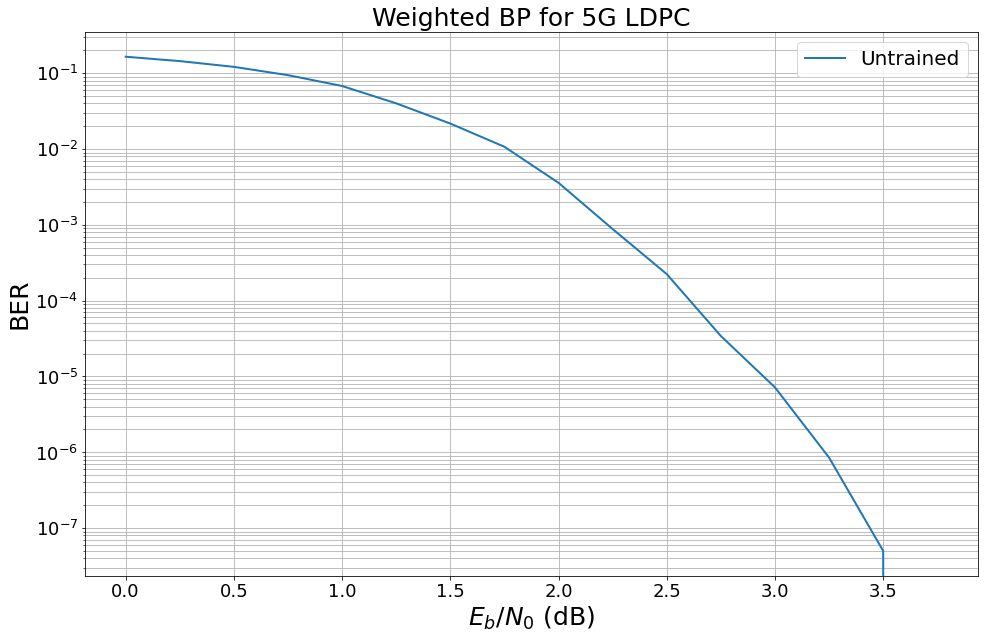

In [13]:
# generate model
num_iter = 10
k = 400
n = 800

model5G = WeightedBP5G(k, n, num_iter=num_iter)

# generate baseline BER
ebno_dbs = np.array(np.arange(0, 4, 0.25))
mc_iters = 100 # number of monte carlo iterations
ber_plot_5G = PlotBER("Weighted BP for 5G LDPC")

# simulate the untrained performance
ber_plot_5G.simulate(model5G,
                     ebno_dbs=ebno_dbs,
                     batch_size=1000,
                     num_target_bit_errors=2000, # stop sim after 2000 bit errors
                     legend="Untrained",
                     soft_estimates=True,
                     max_mc_iter=mc_iters);

And let's train this new model.

In [14]:
# training parameters
batch_size = 1000
train_iter = 200
clip_value_grad = 10 # gradient clipping seems to be important

# smaller training SNR as the new code is longer (=stronger) than before
ebno_db = 1.5 # rule of thumb: train at ber = 1e-2

# only used as metric
bmi = BitwiseMutualInformation()

# try also different optimizers or different hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) 

# and let's go
for it in range(0, train_iter):
    with tf.GradientTape() as tape:
        b, llr, loss = model5G(batch_size, ebno_db) 
    
    grads = tape.gradient(loss, model5G.trainable_variables)
    grads = tf.clip_by_value(grads, -clip_value_grad, clip_value_grad, name=None)
    optimizer.apply_gradients(zip(grads, model5G.trainable_weights))

    # calculate and print intermediate metrics
    if it%10==0:
        # calculate ber
        b_hat = hard_decisions(llr)
        ber = compute_ber(b, b_hat)
        # and print results
        mi = bmi(b, llr).numpy()
        l = loss.numpy()        
        print(f"Current loss: {l:3f} ber: {ber:.4f} bmi: {mi:.3f}".format())
        bmi.reset_states()

Current loss: 1.719550 ber: 0.0211 bmi: 0.922
Current loss: 1.730617 ber: 0.0219 bmi: 0.919
Current loss: 1.762849 ber: 0.0228 bmi: 0.915
Current loss: 1.716993 ber: 0.0221 bmi: 0.918
Current loss: 1.757328 ber: 0.0229 bmi: 0.915
Current loss: 1.714274 ber: 0.0211 bmi: 0.922
Current loss: 1.738381 ber: 0.0228 bmi: 0.915
Current loss: 1.756525 ber: 0.0232 bmi: 0.914
Current loss: 1.680675 ber: 0.0201 bmi: 0.926
Current loss: 1.714153 ber: 0.0213 bmi: 0.923
Current loss: 1.715629 ber: 0.0209 bmi: 0.923
Current loss: 1.719860 ber: 0.0218 bmi: 0.920
Current loss: 1.714336 ber: 0.0211 bmi: 0.921
Current loss: 1.705194 ber: 0.0203 bmi: 0.926
Current loss: 1.732592 ber: 0.0228 bmi: 0.917
Current loss: 1.753809 ber: 0.0241 bmi: 0.911
Current loss: 1.709435 ber: 0.0205 bmi: 0.924
Current loss: 1.724635 ber: 0.0216 bmi: 0.920
Current loss: 1.741667 ber: 0.0218 bmi: 0.919
Current loss: 1.731879 ber: 0.0218 bmi: 0.919


We now simulate the new results and compare it to the untrained results.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6759e-01 | 1.0000e+00 |       67038 |      400000 |         1000 |        1000 |         1.1 |reached target bit errors
     0.25 | 1.4738e-01 | 9.9900e-01 |       58952 |      400000 |          999 |        1000 |         0.9 |reached target bit errors
      0.5 | 1.2264e-01 | 9.9800e-01 |       49055 |      400000 |          998 |        1000 |         0.9 |reached target bit errors
     0.75 | 9.9580e-02 | 9.9100e-01 |       39832 |      400000 |          991 |        1000 |         0.9 |reached target bit errors
      1.0 | 6.8517e-02 | 9.3100e-01 |       27407 |      400000 |          931 |        1000 |         0.9 |reached target bit errors
     1.25 | 4.2555e-02 | 8.2800e-01 |       17022 |      400000 |          

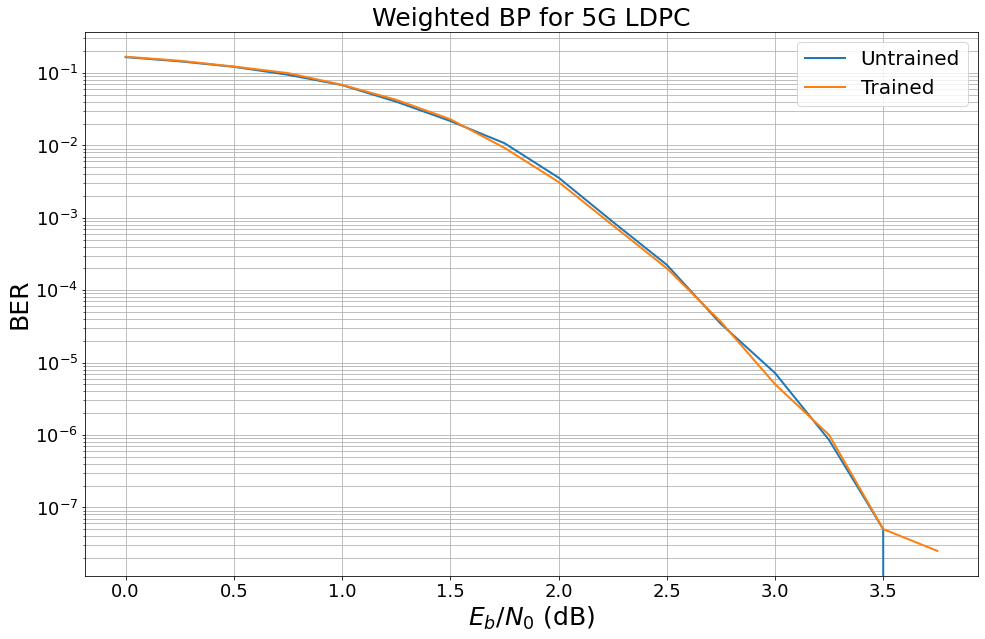

In [15]:
ebno_dbs = np.array(np.arange(0, 4, 0.25))
batch_size = 1000
mc_iters = 100

ber_plot_5G.simulate(model5G,
                     ebno_dbs=ebno_dbs,
                     batch_size=batch_size,
                     num_target_bit_errors=2000, # stop sim after 2000 bit errors
                     legend="Trained",
                     max_mc_iter=mc_iters,
                     soft_estimates=True);

Unfortunately, we observe only very minor gains for the 5G LDPC code. We empirically observed that gain vanishes for more iterations and longer codewords, i.e., for most practical use-cases of the 5G LDPC code the gains are only minor.

However, there may be other `codes on graphs` that benefit from the principle idea of weighted BP - or other channel setups? Feel free to adjust this notebook and train for your favorite code / channel.

Other ideas for own experiments:

- Implement weighted BP with unique weights per iteration.
- Apply the concept to (scaled) min-sum decoding as in [5].
- Can you replace the complete CN update by a neural network?
- Verify the results from all-zero simulations for a *real* system simulation with explicit encoder and random data
- What happens in combination with higher order modulation?

## References

[1] E. Nachmani, Y. Be’ery and D. Burshtein, "Learning to Decode Linear Codes Using Deep Learning,"
IEEE Annual Allerton Conference on Communication, Control, and Computing (Allerton), pp. 341-346., 2016. https://arxiv.org/pdf/1607.04793.pdf

[2] M. Lian, C. Häger, and H. Pfister, "What can machine learning teach us about communications?" IEEE Information Theory Workshop (ITW), pp. 1-5. 2018.

[3] ] M. Pretti, “A message passing algorithm with damping,” J. Statist. Mech.: Theory Practice, p. 11008, Nov. 2005.

[4] J.S. Yedidia, W.T. Freeman and Y. Weiss, "Constructing free energy approximations and Generalized Belief Propagation algorithms," IEEE Transactions on Information Theory, 2005.

[5] E. Nachmani, E. Marciano, L. Lugosch, W. Gross, D. Burshtein and Y. Be’ery, "Deep learning methods for improved decoding of linear codes," IEEE Journal of Selected Topics in Signal Processing, vol. 12, no. 1, pp.119-131, 2018.

### GOD BLESS AMERICA

In [89]:
!pip install pyfinite

Defaulting to user installation because normal site-packages is not writeable


In [90]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Import required Sionna components
from sionna.fec.ldpc import LDPCBPDecoder, LDPC5GEncoder, LDPC5GDecoder
from sionna.utils.metrics import BitwiseMutualInformation
from sionna.fec.utils import GaussianPriorSource, load_parity_check_examples
from sionna.utils import ebnodb2no, hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER

from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [91]:
class WeightedBP(tf.keras.Model):
    """System model for BER simulations of weighted BP decoding based on syndromes.
    
    This model uses `GaussianPriorSource` to mimic the LLRs after demapping of 
    QPSK symbols transmitted over an AWGN channel.
    
    Parameters
    ----------
        pcm: ndarray
            The parity-check matrix of the code under investigation.
        
        num_iter: int 
            Number of BP decoding iterations.       
        
            
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat, syndrome_loss):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k]` of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k]` of 0s and 1s containing the estimated information bits.           
            
        syndrome_loss: tf.float32
            The loss based on the syndrome values.
    """
    def __init__(self, pcm, num_iter=5):
        super().__init__()

        # init components    
        self.decoder = LDPCBPDecoder(pcm,
                                     num_iter=1, # iterations are done via outer loop (to access intermediate results for multi-loss)
                                     stateful=True, # decoder stores internal messages after call
                                     hard_out=False, # we need to access soft-information
                                     cn_type="boxplus",
                                     trainable=True) # the decoder must be trainable, otherwise no weights are generated

        # used to generate llrs during training (see example notebook on all-zero codeword trick)
        self.llr_source = GaussianPriorSource()
        self._num_iter = num_iter

        self.pcm = tf.convert_to_tensor(pcm, dtype=tf.float32)  # Parity-check matrix

    def call(self, batch_size, ebno_db):     
        noise_var = ebnodb2no(ebno_db,
                              num_bits_per_symbol=2, # QPSK
                              coderate=coderate)        
        
        # all-zero CW to calculate loss / BER
        c = tf.zeros([batch_size, n]) 

        # Gaussian LLR source
        llr = self.llr_source([[batch_size, n], noise_var])

        # --- implement multi-loss as proposed by Nachmani et al. [1]---
        msg_vn = None # internal state of decoder
        for i in range(self._num_iter):
            c_hat, msg_vn = self.decoder((llr, msg_vn)) # perform one decoding iteration; decoder returns soft-values

        # Compute the syndrome
        syndrome = tf.linalg.matmul(c_hat, self.pcm, transpose_b=True) % 2
        syndrome_loss = tf.reduce_mean(tf.abs(syndrome))

        return c, c_hat, syndrome_loss


n: 63, k: 45, coderate: 0.714
Total number of weights:  432


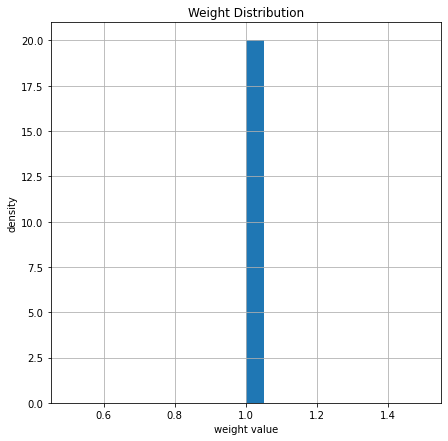

In [92]:
pcm_id = 1 # (63,45) BCH code parity check matrix
pcm, k , n, coderate = load_parity_check_examples(pcm_id=pcm_id, verbose=True)

num_iter = 10 # set number of decoding iterations

# and initialize the model
model = WeightedBP(pcm=pcm, num_iter=num_iter)

# count number of weights/edges
print("Total number of weights: ", np.size(model.decoder.get_weights()))

# and show the weight distribution
model.decoder.show_weights()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 8.9270e-02 | 9.7300e-01 |        5624 |       63000 |          973 |        1000 |         0.3 |reached target bit errors
      1.5 | 7.4270e-02 | 9.0500e-01 |        4679 |       63000 |          905 |        1000 |         0.3 |reached target bit errors
      2.0 | 6.1016e-02 | 8.1200e-01 |        3844 |       63000 |          812 |        1000 |         0.3 |reached target bit errors
      2.5 | 4.6016e-02 | 6.6000e-01 |        2899 |       63000 |          660 |        1000 |         0.3 |reached target bit errors
      3.0 | 3.1611e-02 | 4.9200e-01 |        3983 |      126000 |          984 |        2000 |         0.6 |reached target bit errors
      3.5 | 2.0619e-02 | 3.3650e-01 |        2598 |      126000 |          

(<tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([0.08926984, 0.07426984, 0.06101587, 0.04601587, 0.03161111,
        0.02061905, 0.01339683, 0.00750159, 0.0040582 , 0.00192437,
        0.00092426, 0.00041373])>,
 <tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([0.973     , 0.905     , 0.812     , 0.66      , 0.492     ,
        0.3365    , 0.228     , 0.1388    , 0.07644444, 0.04082353,
        0.01911429, 0.00836364])>)

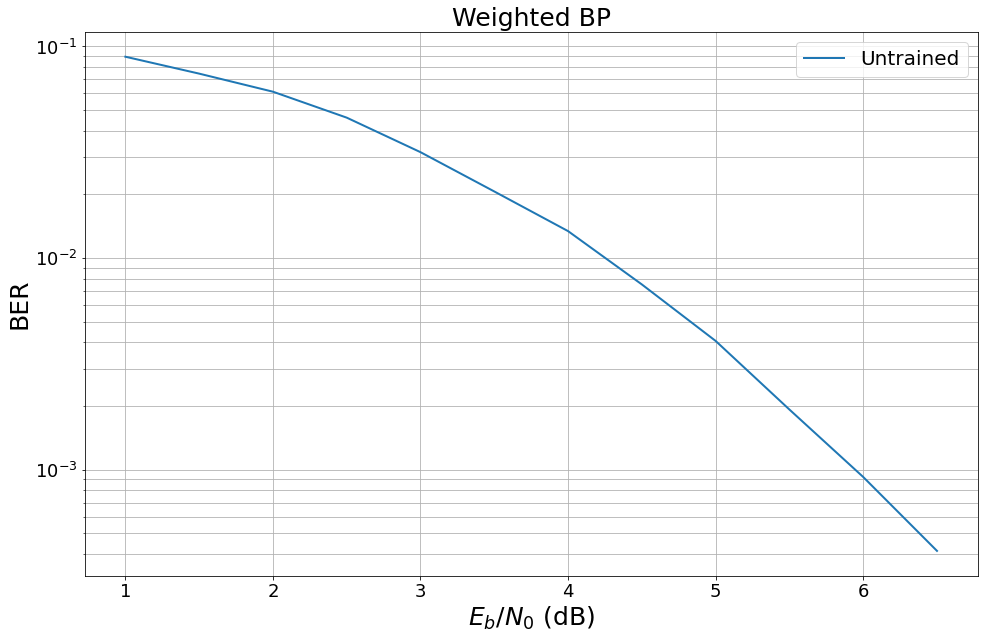

In [93]:
# SNR to simulate the results
ebno_dbs = np.array(np.arange(1, 7, 0.5))
mc_iters = 100 # number of Monte Carlo iterations

# we generate a new PlotBER() object to simulate, store and plot the BER results
ber_plot = PlotBER("Weighted BP")

# simulate and plot the BER curve of the untrained decoder
ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=1000,
                  num_target_bit_errors=2000, # stop sim after 2000 bit errors
                  legend="Untrained",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False)


In [94]:
# training parameters
batch_size = 1000
train_iter = 200
ebno_db = 4.0
clip_value_grad = 10 # gradient clipping for stable training convergence

# try also different optimizers or different hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) 

for it in range(0, train_iter):
    with tf.GradientTape() as tape:
        b, llr, loss = model(batch_size, ebno_db)     

    grads = tape.gradient(loss, model.trainable_variables)
    grads = tf.clip_by_value(grads, -clip_value_grad, clip_value_grad, name=None)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # calculate and print intermediate metrics
    # only for information
    # this has no impact on the training
    if it % 10 == 0: # evaluate every 10 iterations
        # calculate ber from received LLRs
        b_hat = hard_decisions(llr) # hard decided LLRs first
        ber = compute_ber(b, b_hat) 
        # and print results
        l = loss.numpy() # copy loss to numpy for printing
        print(f"Current syndrome loss: {l:.4f} ber: {ber:.4f}")


Current syndrome loss: 1.0002 ber: 0.0127
Current syndrome loss: 1.0043 ber: 0.0145
Current syndrome loss: 0.9960 ber: 0.0145
Current syndrome loss: 0.9910 ber: 0.0115
Current syndrome loss: 1.0031 ber: 0.0126
Current syndrome loss: 1.0032 ber: 0.0106
Current syndrome loss: 0.9994 ber: 0.0127
Current syndrome loss: 0.9983 ber: 0.0115
Current syndrome loss: 0.9953 ber: 0.0157
Current syndrome loss: 1.0007 ber: 0.0136
Current syndrome loss: 0.9986 ber: 0.0141
Current syndrome loss: 1.0014 ber: 0.0142
Current syndrome loss: 0.9895 ber: 0.0136
Current syndrome loss: 1.0040 ber: 0.0148
Current syndrome loss: 0.9990 ber: 0.0137
Current syndrome loss: 0.9952 ber: 0.0133
Current syndrome loss: 1.0007 ber: 0.0127
Current syndrome loss: 0.9969 ber: 0.0137
Current syndrome loss: 1.0028 ber: 0.0113
Current syndrome loss: 0.9993 ber: 0.0137


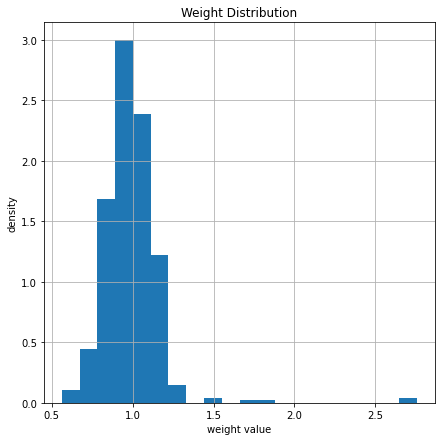

In [95]:
model.decoder.show_weights() # show weights AFTER training


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 9.0492e-02 | 9.7600e-01 |        5701 |       63000 |          976 |        1000 |         0.3 |reached target bit errors
      1.5 | 7.8857e-02 | 9.3200e-01 |        4968 |       63000 |          932 |        1000 |         0.3 |reached target bit errors
      2.0 | 5.9111e-02 | 8.1700e-01 |        3724 |       63000 |          817 |        1000 |         0.3 |reached target bit errors
      2.5 | 4.7857e-02 | 6.9300e-01 |        3015 |       63000 |          693 |        1000 |         0.3 |reached target bit errors
      3.0 | 3.4381e-02 | 5.4500e-01 |        2166 |       63000 |          545 |        1000 |         0.3 |reached target bit errors
      3.5 | 2.1817e-02 | 3.6350e-01 |        2749 |      126000 |          

(<tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([0.09049206, 0.07885714, 0.05911111, 0.04785714, 0.03438095,
        0.02181746, 0.01351323, 0.00780952, 0.00408135, 0.00203869,
        0.00100241, 0.00039251])>,
 <tf.Tensor: shape=(12,), dtype=float64, numpy=
 array([0.976     , 0.932     , 0.817     , 0.693     , 0.545     ,
        0.3635    , 0.22866667, 0.1404    , 0.0775    , 0.0413125 ,
        0.02075758, 0.00860494])>)

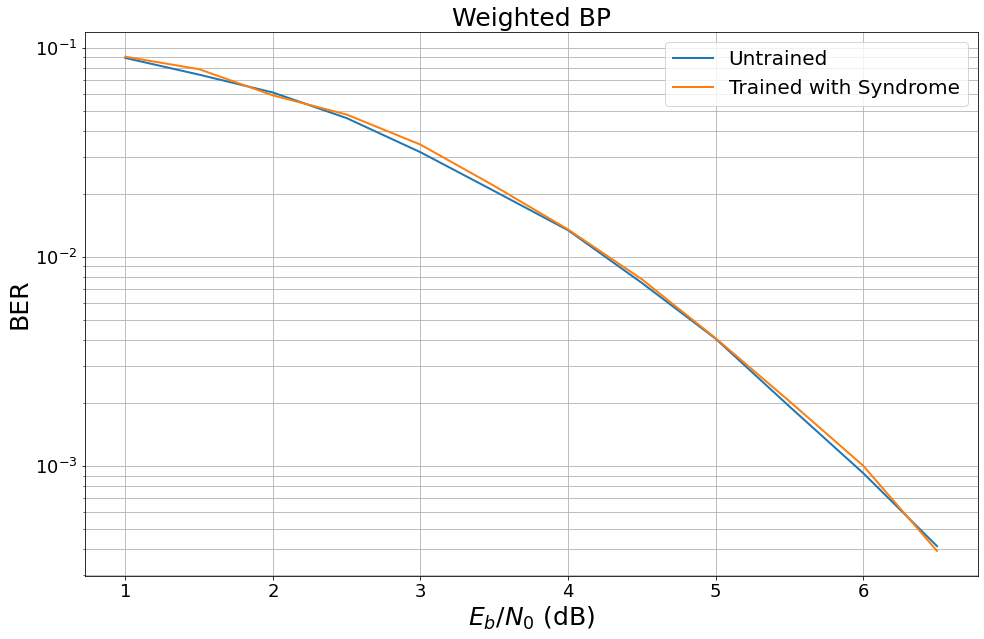

In [96]:
# Compare BER performance
ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=1000,
                  num_target_bit_errors=2000, # stop sim after 2000 bit errors
                  legend="Trained with Syndrome",
                  max_mc_iter=mc_iters,
                  soft_estimates=True)


### Let's now use algebra lol

In [13]:
import numpy as np

class BerlekampMassey:
    def __init__(self, sequence):
        n = len(sequence)
        s = list(map(int, sequence))

        self._f = [1]  # Initializing the polynomial with 1
        b = [1]       # Copy of the previous polynomial
        self._l = 0   # Length of the polynomial
        m = 0         # Position of the last discrepancy
        b_shift = 0   # Shift for polynomial b

        for i in range(n):
            discrepancy = s[i]
            for j in range(1, self._l + 1):
                if i - j >= 0:  # Ensure we are not accessing out of range
                    discrepancy ^= self._f[j] * s[i - j]
            if discrepancy != 0:
                t = self._f[:]
                b_extended = [0] * (i - b_shift) + b
                self._f = self._f + [0] * (len(b_extended) - len(self._f))
                for j in range(len(b_extended)):
                    self._f[j] ^= b_extended[j] * discrepancy
                if 2 * self._l <= i:
                    self._l = i + 1 - self._l
                    b = t
                    b_shift = i
        print("Berlekamp-Massey: Final polynomial:", self._f)

    def get_polynomial(self):
        return self._f

    def get_polynomial_degree(self):
        return self._l

def generate_bch_code(n, k):
    # Example generator polynomial for BCH(15, 7, 5)
    g = [1, 1, 0, 0, 0, 1, 1, 0, 1]
    return np.array(g, dtype=int)

def encode_bch(message, generator_poly, n, k):
    # Padding the message with zeros to match the code length
    padded_message = np.concatenate([message, np.zeros(n - k, dtype=int)])
    print("Padded message:   ", padded_message)
    # Perform polynomial division to find the remainder
    remainder = np.polydiv(padded_message, generator_poly)[1]
    remainder = np.round(remainder) % 2  # Ensure binary coefficients
    print("Remainder:        ", remainder)
    # Pad the remainder to the correct length
    remainder_padded = np.concatenate([np.zeros(n - len(remainder), dtype=int), remainder])
    codeword = (padded_message + remainder_padded).astype(int) % 2
    return codeword

def introduce_noise(codeword, n_errors, rng):
    error_indices = rng.choice(len(codeword), n_errors, replace=False)
    print("Error indices:    ", error_indices)
    noisy_codeword = np.copy(codeword)
    noisy_codeword[error_indices] ^= 1  # Flip the bits at the error indices
    return noisy_codeword

def calculate_syndromes(received, t, n):
    syndromes = []
    for i in range(1, 2 * t + 1):
        syndrome = sum(received[j] * (2 ** (i * j) % n) for j in range(n)) % 2
        syndromes.append(syndrome)
    print("Syndromes:        ", syndromes)
    return np.array(syndromes, dtype=int)

def decode_bch(noisy_codeword, n, k, t):
    syndromes = calculate_syndromes(noisy_codeword, t, n)
    bm = BerlekampMassey(syndromes)
    Lambda = bm.get_polynomial()
    print("Error locator polynomial:", Lambda)
    error_positions = []
    for i in range(n):
        if np.polyval(Lambda[::-1], 2 ** i) % 2 == 0:
            error_positions.append(n - i - 1)
    print("Error positions:  ", error_positions)
    corrected_codeword = np.copy(noisy_codeword)
    for pos in error_positions:
        corrected_codeword[pos] ^= 1
    return corrected_codeword

# Example usage
n = 15  # Length of the codeword
k = 7   # Length of the message
t = 2   # Number of errors the code can correct

rng = np.random.default_rng()
message = rng.integers(0, 2, size=k)
print("Original Message: ", message)

generator_poly = generate_bch_code(n, k)
encoded_message = encode_bch(message, generator_poly, n, k)
print("Encoded Message:  ", encoded_message)

noisy_message = introduce_noise(encoded_message, t, rng)
print("Noisy Message:    ", noisy_message)

decoded_message = decode_bch(noisy_message, n, k, t)
print("Decoded Message:  ", decoded_message)

# Extract original message from corrected codeword
corrected_message = decoded_message[:k]
print("Corrected Message:", corrected_message)


Original Message:  [1 0 1 1 0 1 0]
Padded message:    [1 0 1 1 0 1 0 0 0 0 0 0 0 0 0]
Remainder:         [0. 0. 1. 0. 1. 0. 1. 1.]
Encoded Message:   [1 0 1 1 0 1 0 0 0 1 0 1 0 1 1]
Error indices:     [ 8 10]
Noisy Message:     [1 0 1 1 0 1 0 0 1 1 1 1 0 1 1]
Syndromes:         [0, 1, 0, 0]


IndexError: list index out of range

In [20]:
import numpy as np
from numpy.polynomial import Polynomial

def generate_bch_code(n, k):
    # Example generator polynomial for BCH(15, 7, 5)
    g = [1, 0, 1, 1, 0, 1, 1, 1, 1]
    return np.array(g, dtype=int)

def encode_bch(message, generator_poly, n, k):
    # Padding the message with zeros to match the code length
    padded_message = np.concatenate([message, np.zeros(n - k, dtype=int)])
    # Perform polynomial division to find the remainder
    remainder = np.polydiv(padded_message, generator_poly)[1]
    remainder = np.round(remainder) % 2  # Ensure binary coefficients
    # Pad the remainder to the correct length
    remainder_padded = np.concatenate([np.zeros(n - len(remainder), dtype=int), remainder])
    codeword = (padded_message + remainder_padded).astype(int) % 2
    return codeword

def introduce_noise(codeword, n_errors, rng):
    error_indices = rng.choice(len(codeword), n_errors, replace=False)
    noisy_codeword = np.copy(codeword)
    noisy_codeword[error_indices] ^= 1  # Flip the bits at the error indices
    return noisy_codeword

def calculate_syndromes(received, generator_poly, t):
    n = len(received)
    syndromes = []
    for i in range(1, 2 * t + 1):
        syndrome = np.polyval(received[::-1], 2 ** i) % 2
        syndromes.append(syndrome)
    return np.array(syndromes, dtype=int)

def berlekamp_massey(syndromes, t):
    n = len(syndromes)
    Lambda = np.array([1], dtype=int)
    old_Lambda = np.array([1], dtype=int)
    L = 0
    old_L = 0
    Delta = 1

    for k in range(n):
        Delta_k = syndromes[k]
        for i in range(1, L + 1):
            if i < len(Lambda) and (k - i) < len(syndromes):
                Delta_k ^= Lambda[i] * syndromes[k - i]

        if Delta_k != 0:
            m = -1
            for i in range(k):
                if L == old_L:
                    m = i
                    break

            if m == -1:
                m = k

            if 2 * L <= k:
                new_Lambda = old_Lambda[:]
                old_Lambda = Lambda[:]
                Lambda = np.pad(Lambda, (0, max(0, k + 1 - len(Lambda))), 'constant')
                for i in range(len(new_Lambda)):
                    if (i + k - m) < len(Lambda):
                        Lambda[i + k - m] ^= Delta_k * new_Lambda[i] // Delta
                old_L = L
                L = k + 1 - L
            else:
                old_Lambda = np.pad(old_Lambda, (0, max(0, k + 1 - len(old_Lambda))), 'constant')
                for i in range(len(old_Lambda)):
                    if (i + k - m) < len(Lambda):
                        Lambda[i + k - m] ^= Delta_k * old_Lambda[i] // Delta

            Delta = Delta_k
        old_L = L

    return Lambda

def decode_bch(noisy_codeword, generator_poly, n, k, t):
    syndromes = calculate_syndromes(noisy_codeword, generator_poly, t)
    Lambda = berlekamp_massey(syndromes, t)
    error_positions = np.where(np.polyval(Lambda[::-1], np.arange(n)) == 0)[0]
    corrected_codeword = np.copy(noisy_codeword)
    corrected_codeword[error_positions] ^= 1
    return corrected_codeword

# Example usage
n = 15  # Length of the codeword
k = 7   # Length of the message
t = 1   # Number of errors the code can correct

rng = np.random.default_rng()
message = rng.integers(0, 2, size=k)
print("Original Message:", message)

generator_poly = generate_bch_code(n, k)
encoded_message = encode_bch(message, generator_poly, n, k)
print("Encoded Message:", encoded_message)

noisy_message = introduce_noise(encoded_message, t, rng)
print("Noisy Message:", noisy_message)

decoded_message = decode_bch(noisy_message, generator_poly, n, k, t)
print("Decoded Message:", decoded_message)

# Extract original message from corrected codeword
corrected_message = decoded_message[:k]
print("Corrected Message:", corrected_message)


Original Message: [0 1 0 0 0 0 1]
Encoded Message: [0 1 0 0 0 0 1 1 1 1 1 1 0 1 0]
Noisy Message: [0 1 1 0 0 0 1 1 1 1 1 1 0 1 0]
Decoded Message: [0 1 1 0 0 0 1 1 1 1 1 1 0 1 0]
Corrected Message: [0 1 1 0 0 0 1]


In [15]:
import numpy as np
from operator import xor
from functools import reduce

def lfsr(coefficients, state=[]):
    m = len(coefficients)
    state = state[:m]
    state = state + [1] * (m - len(state))
    while 1:
        state.append(dot(coefficients, state))
        yield state.pop(0)

def fcsr(coefficients, state=[], carry=0):
    m = len(coefficients)
    state = state[:m]
    state = state + [1] * (m - len(state))
    while 1:
        comp = carry + sum([x & y for (x, y) in zip(coefficients, state)])
        state.append(comp % 2)
        carry = comp // 2
        yield state.pop(0)

def berlekamp_massey(S):
    if isinstance(S, str):
        S = list(map(int, tuple(S)))
    m = 0
    N, f = 0, One
    N0, f0 = -1, One
    n = len(S)
    while N < n:
        if S[N] != f.dot(S[:N]):
            if 2 * m > N:
                f = f + f0 * X ** (N - N0)
            else:
                f0, f = f, f + f0 * X ** (N - N0)
                N0 = N
                m = N + 1 - m
        N += 1
        yield f[:-1]
    print("The LFSR is constructed.")
    yield f[:-1]

def run_berlekamp_massey(S):
    L = berlekamp_massey(S)
    while 1:
        try:
            R = next(L)
        except StopIteration:
            return R

class Poly(list):
    def __str__(self):
        L = ["x^%s" % (k,) for (k, x) in enumerate(self[::-1]) if x == 1]
        L.reverse()
        return "+".join(L)

    def __add__(self, other):
        if len(self) < len(other):
            return other + self
        else:
            k = len(self) - len(other)
            new = [a ^ b for (a, b) in zip(self, ([0] * k) + other)]
            try:
                while new[0] == 0:
                    new.pop(0)
            except IndexError:
                new = []
            return Poly(new)

    def dot(self, S):
        m = len(self)
        N = len(S)
        C = self[:-1]
        S = S[N - m + 1:]
        return dot(C, S)

    def __mul__(self, other):
        deg = len(self) + len(other) - 2
        prod = [0] * (deg + 1)
        for k, x in enumerate(self):
            for j, y in enumerate(other):
                prod[k + j] ^= (x & y)
        return Poly(prod)

    def __pow__(self, ex):
        if ex == 0:
            return Poly([1])
        else:
            return self * (self ** (ex - 1))

def dot(x, y):
    return reduce(xor, [a & b for (a, b) in zip(x, y)], 0)

X = Poly([1, 0])
One = Poly([1])

def generate_bch_code(n, k):
    g = [1, 1, 0, 0, 0, 1, 1, 0, 1]
    return np.array(g, dtype=int)

def encode_bch(message, generator_poly, n, k):
    padded_message = np.concatenate([message, np.zeros(n - k, dtype=int)])
    print("Padded message:   ", padded_message)
    remainder = np.polydiv(padded_message, generator_poly)[1]
    remainder = np.round(remainder) % 2
    print("Remainder:        ", remainder)
    remainder_padded = np.concatenate([np.zeros(n - len(remainder), dtype=int), remainder])
    codeword = (padded_message + remainder_padded).astype(int) % 2
    return codeword

def introduce_noise(codeword, n_errors, rng):
    error_indices = rng.choice(len(codeword), n_errors, replace=False)
    print("Error indices:    ", error_indices)
    noisy_codeword = np.copy(codeword)
    noisy_codeword[error_indices] ^= 1
    return noisy_codeword

def calculate_syndromes(received, t, n):
    syndromes = []
    for i in range(1, 2 * t + 1):
        syndrome = sum(received[j] * (2 ** (i * j) % n) for j in range(n)) % 2
        syndromes.append(syndrome)
    print("Syndromes:        ", syndromes)
    return np.array(syndromes, dtype=int)

def decode_bch(noisy_codeword, n, k, t):
    syndromes = calculate_syndromes(noisy_codeword, t, n)
    if np.all(syndromes == 0):
        print("No errors detected.")
        return noisy_codeword
    lfsr = run_berlekamp_massey(syndromes)
    print("Error locator polynomial:", lfsr)
    error_positions = []
    for i in range(n):
        if np.polyval(lfsr[::-1], 2 ** i) % 2 == 0:
            error_positions.append(n - i - 1)
    print("Error positions:  ", error_positions)
    corrected_codeword = np.copy(noisy_codeword)
    for pos in error_positions:
        corrected_codeword[pos] ^= 1
    return corrected_codeword

# Example usage
n = 15
k = 7
t = 2

rng = np.random.default_rng()
message = rng.integers(0, 2, size=k)
print("Original Message: ", message)

generator_poly = generate_bch_code(n, k)
encoded_message = encode_bch(message, generator_poly, n, k)
print("Encoded Message:  ", encoded_message)

noisy_message = introduce_noise(encoded_message, t, rng)
print("Noisy Message:    ", noisy_message)

decoded_message = decode_bch(noisy_message, n, k, t)
print("Decoded Message:  ", decoded_message)

corrected_message = decoded_message[:k]
print("Corrected Message:", corrected_message)


Original Message:  [1 0 1 0 0 0 0]
Padded message:    [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Remainder:         [0. 1. 1. 1. 0. 1. 1. 1.]
Encoded Message:   [1 0 1 0 0 0 0 0 1 1 1 0 1 1 1]
Error indices:     [9 5]
Noisy Message:     [1 0 1 0 0 1 0 0 1 0 1 0 1 1 1]
Syndromes:         [1, 0, 1, 0]
The LFSR is constructed.
Error locator polynomial: [1, 0]
Error positions:   []
Decoded Message:   [1 0 1 0 0 1 0 0 1 0 1 0 1 1 1]
Corrected Message: [1 0 1 0 0 1 0]
